# Lab10 (Student) — Fraud Analytics EDA & Model Calls

Notebook นี้ใช้สำหรับ Task A–D: โหลดข้อมูล, สร้าง feature, และเรียก API

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

DATA = Path('..') / 'data'
TX = DATA / 'Transaction Data' / 'transaction_records.csv'
META = DATA / 'Transaction Data' / 'transaction_metadata.csv'
CUST = DATA / 'Customer Profiles' / 'customer_data.csv'
ACT = DATA / 'Customer Profiles' / 'account_activity.csv'
MERCH = DATA / 'Merchant Information' / 'merchant_data.csv'
FRAUD = DATA / 'Fraudulent Patterns' / 'fraud_indicators.csv'

df_tx = pd.read_csv(TX)
df_meta = pd.read_csv(META)
df_cust = pd.read_csv(CUST)
df_act = pd.read_csv(ACT)
df_merch = pd.read_csv(MERCH)
df_fraud = pd.read_csv(FRAUD)

df_tx.head()

,TransactionID,Amount,CustomerID
0,1,55.530334,1952
1,2,12.881180,1027
2,3,50.176322,1955
3,4,41.634001,1796
4,5,78.122853,1946


In [2]:
# Join ขั้นพื้นฐาน
df = df_tx.merge(df_meta, on='TransactionID', how='left')
df = df.merge(df_cust, on='CustomerID', how='left')
df = df.merge(df_act, on='CustomerID', how='left')
df = df.merge(df_merch, on='MerchantID', how='left')
df = df.merge(df_fraud[['TransactionID','FraudIndicator']], on='TransactionID', how='left')

# Create IsFraud column
df['IsFraud'] = df['FraudIndicator'].fillna(0).astype(int)

df.shape, df.columns[:20]

((1000, 14),
 Index(['TransactionID', 'Amount', 'CustomerID', 'Timestamp', 'MerchantID',
        'Name', 'Age', 'Address', 'AccountBalance', 'LastLogin', 'MerchantName',
        'Location', 'FraudIndicator', 'IsFraud'],
       dtype='object'))

In [3]:
# Profiling
print('transactions:', df['TransactionID'].nunique())
print('customers:', df['CustomerID'].nunique())
print('merchants:', df['MerchantID'].nunique())
print('fraud rate:', df['IsFraud'].mean())

df[['Amount']].describe()

transactions: 1000
customers: 636
merchants: 651
fraud rate: 0.045


,Amount
count,1000.000000
mean,55.394871
std,25.070809
min,10.006933
25%,34.502315
50%,57.844325
75%,75.858576
max,99.887410


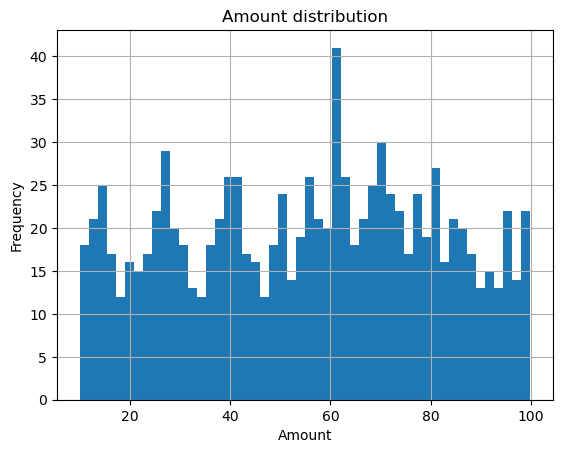

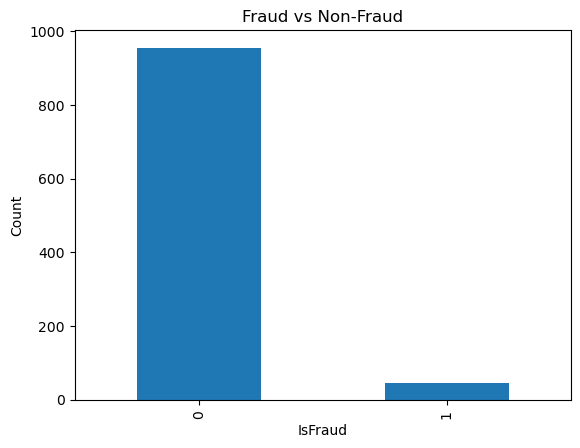

In [4]:
df['Amount'].hist(bins=50)
plt.title('Amount distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

df['IsFraud'].value_counts().plot(kind='bar')
plt.title('Fraud vs Non-Fraud')
plt.xlabel('IsFraud')
plt.ylabel('Count')
plt.show()

In [5]:
# Feature Engineering (ตัวอย่างแบบง่าย)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['LastLogin'] = pd.to_datetime(df['LastLogin'], errors='coerce')
df['Hour'] = df['Timestamp'].dt.hour.fillna(0).astype(int)

# DaysSinceLastLogin
df['DaysSinceLastLogin'] = (df['Timestamp'] - df['LastLogin']).dt.days.fillna(0).astype(int)

# TxCount_1h: นับจำนวนธุรกรรมต่อ Customer ต่อชั่วโมง
df['ts_hour'] = df['Timestamp'].dt.floor('H')
df['TxCount_1h'] = df.groupby(['CustomerID','ts_hour'])['TransactionID'].transform('count')

# Amount-based features
cust_avg = df.groupby('CustomerID')['Amount'].transform('mean')
df['AmountToCustomerAvg'] = (df['Amount'] / cust_avg).replace([float('inf')], 0).fillna(0)
df['AnomalyScore'] = ((df['Amount'] - cust_avg) / cust_avg).abs().fillna(0)

df[['Hour','DaysSinceLastLogin','TxCount_1h','AmountToCustomerAvg','AnomalyScore']].head()

,Hour,DaysSinceLastLogin,TxCount_1h,AmountToCustomerAvg,AnomalyScore
0,0,-951,1,1.016907,0.016907
1,1,-26,1,1.000000,0.000000
2,2,-954,1,0.972716,0.027284
3,3,-795,1,0.835199,0.164801
4,4,-945,1,1.000000,0.000000


## เรียก API (ต้องรัน docker compose แล้ว)
- POST /fraud/train
- GET /fraud/top
- POST /fraud/score
- POST /fraud/explain

In [6]:
import requests
import os

# Use 'api' service name when running in Docker, 'localhost' otherwise
API = 'http://api:8000' if os.path.exists('/.dockerenv') else 'http://localhost:8000'
print(f"Using API: {API}")

r = requests.post(f'{API}/fraud/train')
print(f"Status: {r.status_code}")
r.json()

Using API: http://api:8000
Status: 200


{'status': 'trained',
 'n_rows': 1000,
 'label_fraud_rate': 0.045,
 'balanced_fraud_rate': 0.5,
 'train_samples': 216,
 'cv_folds': 5,
 'cv_confusion_matrix': [[493, 271], [21, 15]],
 'cv_precision': 0.05221049009105215,
 'cv_recall': 0.42142857142857143,
 'cv_f1': 0.09273604635711372,
 'cv_roc_auc': 0.5508807250970563,
 'test_confusion_matrix': [[118, 73], [4, 5]],
 'test_precision': 0.0641025641025641,
 'test_recall': 0.5555555555555556,
 'test_f1': 0.11494252873563218,
 'notes': 'IsolationForest (unsupervised). Ensemble (RF+GB) with hybrid balancing (undersample majority + SMOTE oversample minority). Using 5-Fold Stratified CV with threshold=0.30 for balanced evaluation.'}

In [7]:
top = requests.get(f'{API}/fraud/top', params={'limit':10}).json()['items']
top[:2]

[{'TransactionID': 51,
  'IForestRisk': 0.0015144684414128973,
  'ShadowProba': 0.2739542477340603,
  'Amount': 42.07616320785515,
  'CustomerID': 1044,
  'MerchantID': 2638,
  'FraudIndicator': 0},
 {'TransactionID': 10,
  'IForestRisk': 0.0005961208613909919,
  'ShadowProba': 0.2169403491330346,
  'Amount': 17.245409041786953,
  'CustomerID': 1574,
  'MerchantID': 2638,
  'FraudIndicator': 0}]

In [8]:
tx_id = int(top[0]['TransactionID'])
print(f"Testing Transaction ID: {tx_id}")

score = requests.post(f'{API}/fraud/score', json={'transaction_id': tx_id}).json()
explain = requests.post(f'{API}/fraud/explain', json={'transaction_id': tx_id, 'top_k': 5}).json()

print("\nScore:")
print(score)
print("\nExplanation:")
print(explain)

Testing Transaction ID: 51

Score:
{'iforest_decision_function': -0.0015144684414128973, 'iforest_risk_score': 0.0015144684414128973, 'shadow_model_pred': 1, 'shadow_model_proba': 0.2739542477340603}

Explanation:
{'method': 'value_magnitude', 'top_factors': [{'feature': 'DaysSinceLastLogin', 'contribution': 1.5949386622572366}, {'feature': 'DayOfWeek', 'contribution': -1.476168840844461}, {'feature': 'Age', 'contribution': -1.4272816261966899}, {'feature': 'Hour', 'contribution': -1.3737346025734039}, {'feature': 'AnomalyScore', 'contribution': -1.0815420780362677}], 'note': 'Basic feature value magnitude ranking.'}
